In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns
from itertools import combinations

In [15]:
# Mapping of state abbreviations to full state names
state_abbrev_to_name = { 'AL': 'Alabama', 'AK': 'Alaska', 'AS': 'American Samoa', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'DC': 'District of Columbia', 'FL': 'Florida', 'GA': 'Georgia', 'GU': 'Guam', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'MP': 'Northern Mariana Islands', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VI': 'Virgin Islands', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming' }

census_df = pd.read_csv('2020_census_aggregated_by_state_with_ratio.csv')
# Calculate the total population per state by summing all age groups
age_columns = census_df.columns[census_df.columns.str.contains('years')]  # Columns containing 'years'
census_df['Total_Population'] = census_df[age_columns].sum(axis=1)

# Read the CMS data CSV file
cms_df = pd.read_csv('ProviderInfo_Download_2020_aggregated_by_state.csv')

# join the two dataframes on the state column
df = pd.merge(census_df, cms_df, on='State', how='left')

# Convert 'total_residents' from string to float
df['total_residents'] = df['total_residents'].astype(float)

# Calculate the ratio of total nursing home residents to total state population
df['NursingHomeResidents_to_TotalPopulation_Ratio'] = df['total_residents'] / df['Total_Population']

print(df.head())


      State  Total population  Under 5 years  5 to 9 years  10 to 14 years  \
0  New York          40402498        2121220       2256060         2383166   
1   Alabama           5024279         286529        302637          325031   
2    Alaska            733391          48104         51054           51344   
3   Arizona           7151502         392370        443878          485297   
4  Arkansas           3011524         179575        192794          205837   

   15 to 19 years  20 to 24 years  25 to 29 years  30 to 34 years  \
0         2553604         2783826         2964752         2947160   
1          338475          345931          314244          311116   
2           47433           49456           55058           56981   
3          485891          477713          473578          462909   
4          204915          198109          188836          190366   

   35 to 39 years  ...  60 to 64 years  65 to 69 years  70 to 74 years  \
0         2679724  ...         2626806    

In [18]:
def analyze_age_ratio_correlation(df, age_group1, age_group2, plot=False):
    """
    Calculates the ratio of sum of age_group1 columns to sum of age_group2 columns,
    computes the Pearson correlation coefficient between this ratio and 'NursingHomeResidents_to_TotalPopulation_Ratio',
    and optionally plots the data.

    Parameters:
    df (DataFrame): The DataFrame containing the data.
    age_group1 (list of str): List of column names for the first age group.
    age_group2 (list of str): List of column names for the second age group.
    plot (bool): If True, plots the data. Default is False.

    Returns:
    corr_coef (float): The Pearson correlation coefficient.
    p_value (float): The p-value for the correlation.
    """

    # Work on a copy to avoid modifying the original DataFrame
    df = df.copy()

    # Sum the age groups
    df['Group1_Sum'] = df[age_group1].sum(axis=1)
    df['Group2_Sum'] = df[age_group2].sum(axis=1)

    # Compute the ratio
    df['Group1_to_Group2_Ratio'] = np.where(
        df['Group2_Sum'] != 0,
        df['Group1_Sum'] / df['Group2_Sum'],
        np.nan
    )

    # Clean the DataFrame
    cleaned_df = df.dropna(subset=['Group1_to_Group2_Ratio', 'NursingHomeResidents_to_TotalPopulation_Ratio'])

    # Calculate Pearson correlation coefficient and p-value
    corr_coef, p_value = pearsonr(
        cleaned_df['Group1_to_Group2_Ratio'],
        cleaned_df['NursingHomeResidents_to_TotalPopulation_Ratio']
    )

    print(f"Pearson correlation coefficient: {corr_coef:.4f}")
    print(f"P-value: {p_value:.4f}")

    if plot:
        # Sort the DataFrame by 'Group1_to_Group2_Ratio'
        df_sorted = df.sort_values('Group1_to_Group2_Ratio', ascending=False)

        # Create figure and axis objects
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot bar chart of the ratio on ax1
        ax1.bar(df_sorted['State'], df_sorted['Group1_to_Group2_Ratio'], color='skyblue', label='Group1 to Group2 Ratio')
        ax1.set_xlabel('State')
        ax1.set_ylabel('Group1 to Group2 Ratio')
        ax1.tick_params(axis='x', rotation=90)

        # Create a secondary y-axis
        ax2 = ax1.twinx()

        # Plot line chart of nursing home residents to total population ratio on ax2
        ax2.plot(df_sorted['State'], df_sorted['NursingHomeResidents_to_TotalPopulation_Ratio'], color='red', marker='o', label='Nursing Home Residents / Total Population')
        ax2.set_ylabel('Nursing Home Residents to Total Population Ratio')

        # Add a title and adjust the layout
        plt.title('Age Group Ratios by State with Nursing Home Residents to Total Population Ratio')
        plt.tight_layout()

        # Add legends
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

        # Show the bar and line chart
        plt.show()

        # Create a scatter plot without different colors and no legend
        plt.figure(figsize=(10, 6))
        plt.scatter(
            cleaned_df['Group1_to_Group2_Ratio'],
            cleaned_df['NursingHomeResidents_to_TotalPopulation_Ratio'],
            color='blue'
        )

        # Add a regression line
        sns.regplot(
            x='Group1_to_Group2_Ratio',
            y='NursingHomeResidents_to_TotalPopulation_Ratio',
            data=cleaned_df,
            scatter=False,  # Don't plot the scatter plot again
            color='red',
            line_kws={'label': f"Correlation: {corr_coef:.2f}"}
        )

        plt.xlabel('Group1 to Group2 Ratio')
        plt.ylabel('Nursing Home Residents to Total Population Ratio')
        plt.title('Correlation between Age Group Ratio and Nursing Home Residents Ratio')
        plt.grid(True)
        plt.show()

    return corr_coef, p_value

Pearson correlation coefficient: 0.5407
P-value: 0.0000


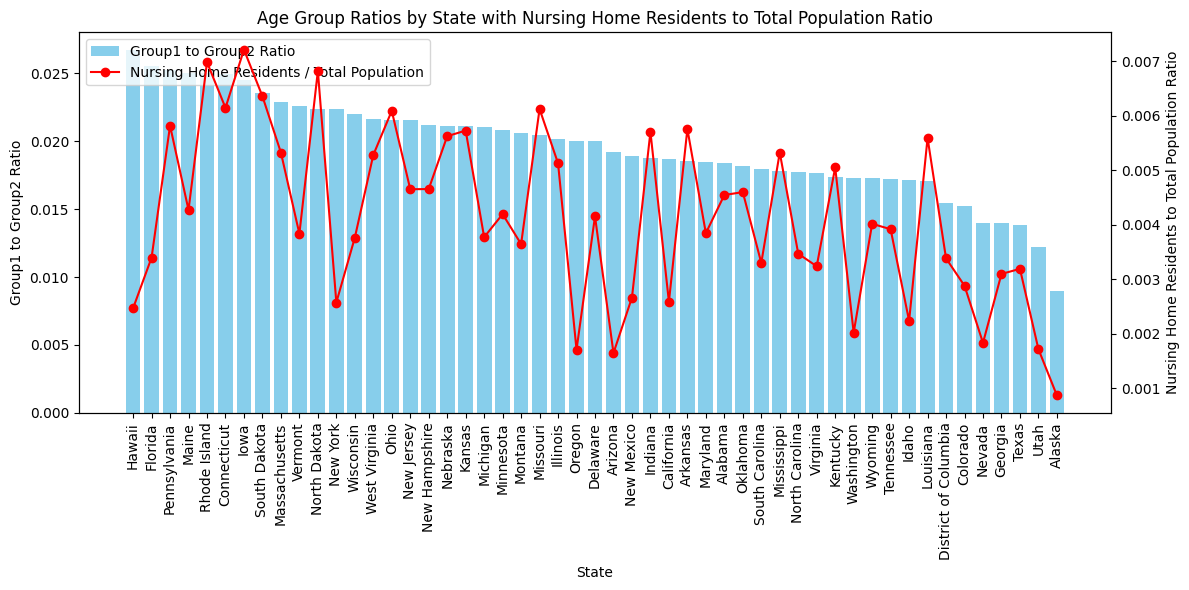

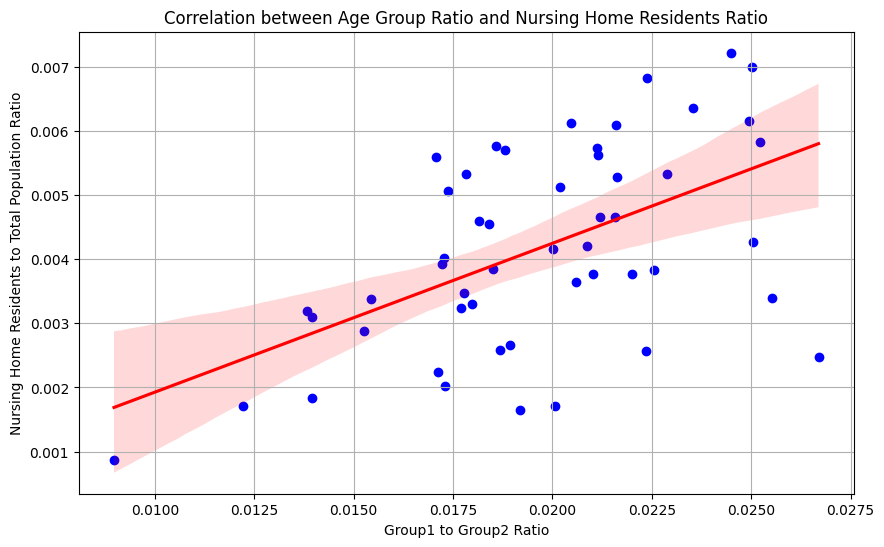

In [19]:
all_age_groups = [col for col in df.columns if 'years' in col and col != '85 years and over']

# Define the age groups
age_group1 = ['85 years and over']

# Call the function
corr_coef, p_value = analyze_age_ratio_correlation(df, age_group1, all_age_groups, plot=True)

Pearson correlation coefficient: 0.6696
P-value: 0.0000


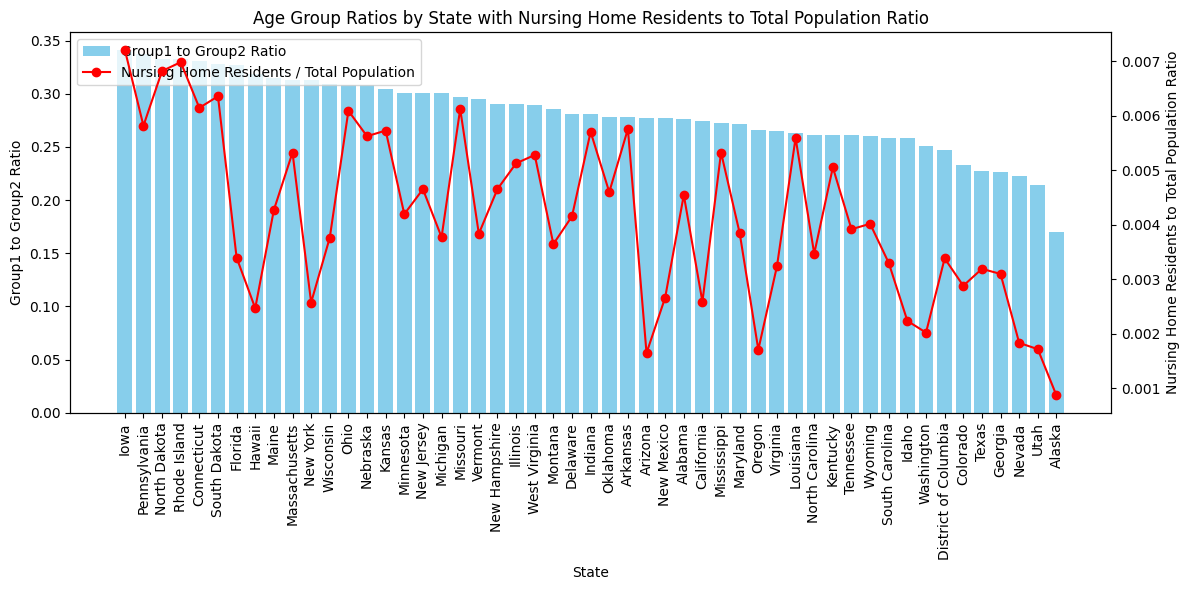

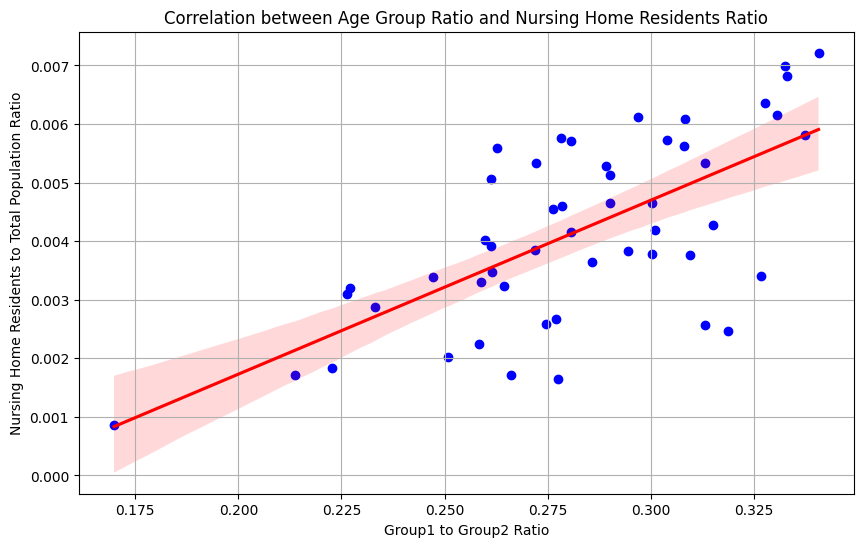

0.6696277983635516 7.738034295568584e-08


In [21]:
# Define the age groups
age_group1 = ['80 to 84 years', '85 years and over']
# age_group2 = ['40 to 44 years']
age_group2 = ['40 to 44 years', '70 to 74 years', '75 to 79 years']

# Call the function
corr_coef, p_value = analyze_age_ratio_correlation(df, age_group1, age_group2, plot=True)
print(corr_coef, p_value)


0.0008678862980320183
0.007216751416528934
0.1698496310391238
0.34068744593992834


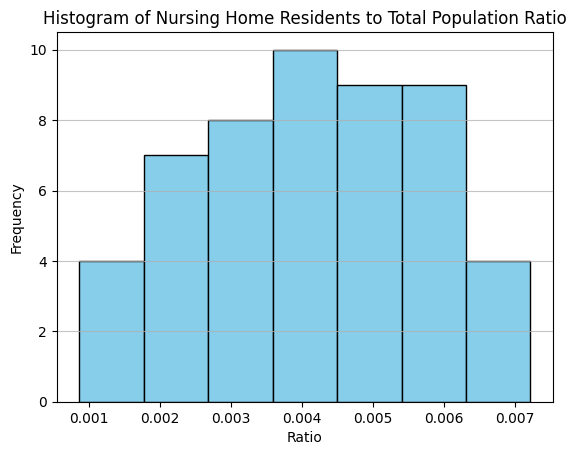

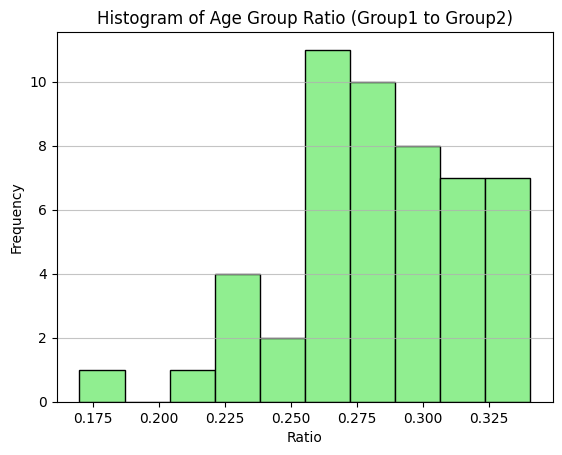

In [34]:
# Calculate the sums of the specified age groups
df['Group1_Sum'] = df[age_group1].sum(axis=1)
df['Group2_Sum'] = df[age_group2].sum(axis=1)

# Calculate the ratio of Group1 to Group2
df['Group1_to_Group2_Ratio'] = df['Group1_Sum'] / df['Group2_Sum']

# print the smallest and largest values of the nursing home residents to total population ratio
print(df['NursingHomeResidents_to_TotalPopulation_Ratio'].min())
print(df['NursingHomeResidents_to_TotalPopulation_Ratio'].max())

# print the smallest and largest values of the age group ratio
print(df['Group1_to_Group2_Ratio'].min())
print(df['Group1_to_Group2_Ratio'].max())

# Create a histogram of the nursing home residents to total population ratio
plt.hist(df['NursingHomeResidents_to_TotalPopulation_Ratio'], bins=7, color='skyblue', edgecolor='black')
plt.title('Histogram of Nursing Home Residents to Total Population Ratio')
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

# Create a histogram of the age group ratio (Group1 to Group2)
plt.hist(df['Group1_to_Group2_Ratio'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Histogram of Age Group Ratio (Group1 to Group2)')
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Optimal λ for Nursing Home Residents Ratio: 0.8757
Optimal λ for Group1 to Group2 Ratio: 2.5449


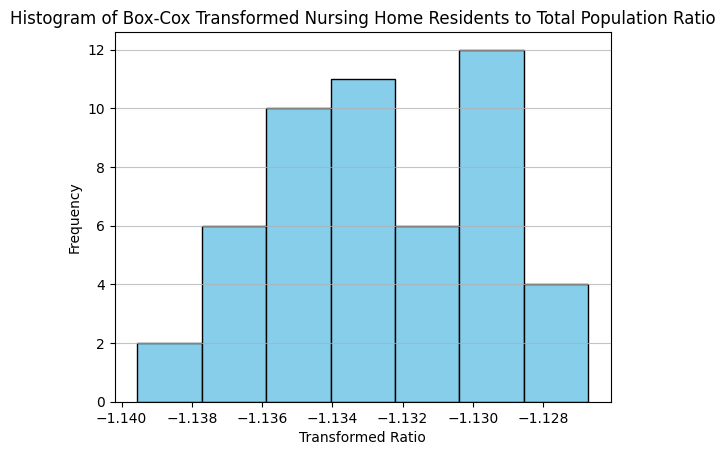

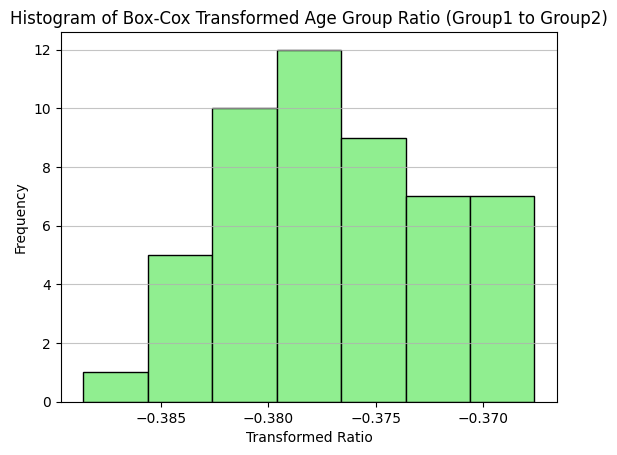

In [33]:
from scipy.stats import boxcox

# Filter out non-positive values
df_positive = df[(df['NursingHomeResidents_to_TotalPopulation_Ratio'] > 0) & 
                 (df['Group1_to_Group2_Ratio'] > 0)].copy()

# Apply Box-Cox transformation
df_positive['BoxCox_NursingHomeResidents_Ratio'], lam_nh = boxcox(df_positive['NursingHomeResidents_to_TotalPopulation_Ratio'])
df_positive['BoxCox_Group1_to_Group2_Ratio'], lam_g = boxcox(df_positive['Group1_to_Group2_Ratio'])

print(f'Optimal λ for Nursing Home Residents Ratio: {lam_nh:.4f}')
print(f'Optimal λ for Group1 to Group2 Ratio: {lam_g:.4f}')

# Plot histograms
plt.hist(df_positive['BoxCox_NursingHomeResidents_Ratio'], bins=7, color='skyblue', edgecolor='black')
plt.title('Histogram of Box-Cox Transformed Nursing Home Residents to Total Population Ratio')
plt.xlabel('Transformed Ratio')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

plt.hist(df_positive['BoxCox_Group1_to_Group2_Ratio'], bins=7, color='lightgreen', edgecolor='black')
plt.title('Histogram of Box-Cox Transformed Age Group Ratio (Group1 to Group2)')
plt.xlabel('Transformed Ratio')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Correlation Coefficient: 0.0529
P-value: 0.712623


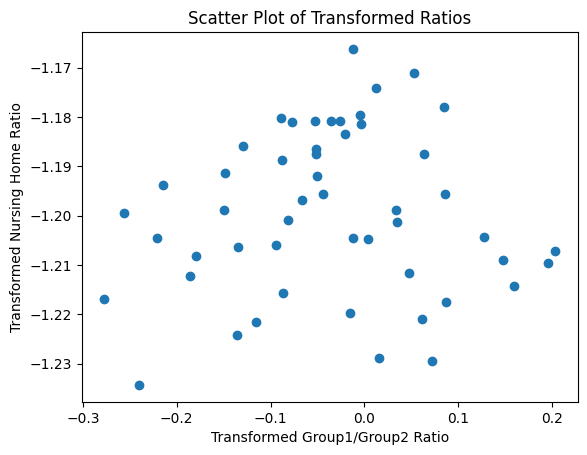

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, boxcox
import matplotlib.pyplot as plt

# Configuration Section
INPUT_CENSUS_FILE = 'census_aggregated_by_state_2020.csv'
INPUT_CMS_FILE = 'cms_aggregated_by_state_2020.csv'

# Define Group1 Ages
GROUP1_AGE = ['65 to 69 years', '70 to 74 years', '75 to 79 years', '80 to 84 years', '85 years and over']

# Define Group2 Ages (Manually Input)
GROUP2_AGE = ['40 to 44 years', '45 to 49 years', '50 to 54 years']  # Ages 40 to 50

# Population type to analyze
POPULATION_TYPE = 'Total population'

# Read input files
census_df = pd.read_csv(INPUT_CENSUS_FILE)
cms_df = pd.read_csv(INPUT_CMS_FILE)

# Adjust census data column names to a simpler naming convention
census_df.rename(columns={
    'Count!!SEX AND AGE!!Total population': 'Total_Population',
    'Count!!SEX AND AGE!!Male population': 'Male_Population',
    'Count!!SEX AND AGE!!Female population': 'Female_Population'
}, inplace=True)

# Merge the two dataframes on the 'State' column
df = pd.merge(census_df, cms_df, on='State', how='left')

# Convert 'total_residents' from string to float
df['total_residents'] = df['total_residents'].astype(float)

# Function to extract census age group columns for a given population type and age groups
def get_age_group_columns(df, population_type, age_groups):
    prefix = f'Count!!SEX AND AGE!!{population_type}!!'
    age_group_columns = [f'{prefix}{age}' for age in age_groups if f'{prefix}{age}' in df.columns]
    return age_group_columns

def perform_analysis():
    population_type = POPULATION_TYPE
    population_key = population_type.replace(" population", "").replace(" ", "_")
    total_population_column = f'{population_key}_Population'

    # Calculate the total number of people in GROUP1_AGE for the specified population type
    group1_columns = get_age_group_columns(df, population_type, GROUP1_AGE)
    df['Group1_Sum'] = df[group1_columns].sum(axis=1)

    # Calculate the specified ratio
    df['NursingHome_Ratio'] = (.83 * df['total_residents']) / df['Group1_Sum']

    # Calculate the total number of people in GROUP2_AGE for the specified population type
    group2_columns = get_age_group_columns(df, population_type, GROUP2_AGE)
    df['Group2_Sum'] = df[group2_columns].sum(axis=1)

    # Compute the ratio of Group1_Sum to Group2_Sum
    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = np.where(df['Group2_Sum'] != 0, df['Group1_Sum'] / df['Group2_Sum'], np.nan)

    # Mask invalid values
    valid_mask = ~np.isnan(ratio) & ~np.isnan(df['NursingHome_Ratio'])
    ratio = ratio[valid_mask]
    nursing_home_ratio = df['NursingHome_Ratio'][valid_mask]

    # Ensure the data is strictly positive for Box-Cox transformation
    positive_mask = (ratio > 0) & (nursing_home_ratio > 0)
    ratio = ratio[positive_mask]
    nursing_home_ratio = nursing_home_ratio[positive_mask]

    if len(ratio) > 1:
        # Apply Box-Cox transformation
        ratio_transformed, _ = boxcox(ratio)
        nh_ratio_transformed, _ = boxcox(nursing_home_ratio)

        # Compute Pearson correlation
        corr_coef, p_value = pearsonr(ratio_transformed, nh_ratio_transformed)
        print(f"Correlation Coefficient: {corr_coef:.4f}")
        print(f"P-value: {p_value:.6f}")

        # Plot the scatter plot
        plt.scatter(ratio_transformed, nh_ratio_transformed)
        plt.title('Scatter Plot of Transformed Ratios')
        plt.xlabel('Transformed Group1/Group2 Ratio')
        plt.ylabel('Transformed Nursing Home Ratio')
        plt.show()
    else:
        print("Not enough data points for correlation analysis.")

if __name__ == "__main__":
    perform_analysis()